# Algorithm Performance Profile

Produce an algorithm profile following an experiment with `doframework`. 

In [1]:
import os
import yaml
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from e2e import api
from e2e.flow.metrics import files_from_solution
from e2e.core.gp import find_modal

# Configs

In [2]:
configs_path = '..' # TODO: provide path
configs_file = 'configs.yaml'

with open(os.path.join(configs_path,configs_file),'r') as file:
    try:
        configs = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)        

# S3

In [3]:
s3 = api._get_s3_object(configs)
buckets = api._get_buckets(configs)

solutions_bucket = s3.Bucket(buckets['solutions'])
solution_files = solutions_bucket.objects.all() # use .limit(10) for partial

# Problem Type

A minimum or maximum problems in experiment.

In [4]:
opt = 'min'

# Fetch Results

In [5]:
rel_perfs = []

for file in solution_files:
    
    solution_name = file.key    
    
    solution_obj = solutions_bucket.Object(solution_name).get()
    solution = json.load(solution_obj['Body'])
        
    assoc_files = files_from_solution(solution_name)
    
    # get relevant objective
    objective_name = assoc_files['objective']
    objective_obj = s3.Bucket(buckets['objectives_dest']).Object(objective_name).get()
    objective = json.load(objective_obj['Body'])
    
    # get relevant data
    data_name = assoc_files['data']
    data_obj = s3.Bucket(buckets['data_dest']).Object(data_name).get()      
    data = pd.read_csv(data_obj['Body'])
    dim = data.iloc[:,:-1].shape[-1]
        
    if solution['solution'][opt] != 'FAILED':
        
        solution_val = solution['solution'][opt]['value']
        true_min_val = objective['optimum']['min']['value']
        true_max_val = objective['optimum']['max']['value']

        rel_perf = (solution_val-true_min_val)/(true_max_val-true_min_val)
        rel_perfs.append([solution_name,objective_name,data_name,dim,rel_perf,True])
        
    else:
        
        rel_perfs.append([solution_name,objective_name,data_name,dim,np.nan,False])        
            

# Performance

In [6]:
df = pd.DataFrame(rel_perfs,columns=['solution','objective','data','dimension','performance','success'])

In [7]:
df[['solution','dimension','performance','success']].head()

,solution,dimension,performance,success
0,solution_021bza94_gzcbt1h0_u8edegz2.json,7,0.638678,True
1,solution_021bza94_pi14x9ir_b45r683m.json,7,0.815320,True
2,solution_0221y7aj_137uq28j_5ph79z0t.json,7,0.588843,True
3,solution_0221y7aj_2x8ln8v8_kphpd713.json,7,0.269693,True
4,solution_025x6vi5_iledexwj_rte37s8q.json,7,0.373057,True


In [8]:
solution_num = df.shape[0]
solution_good = df[~df.performance.isna()].shape[0]

print('Reviewed {} solutions.'.format(solution_num))
print('Of those, {:.2f}% succsessful.'.format(100*(solution_good/solution_num)))

Reviewed 721 solutions.
Of those, 94.87% succsessful.


# Profile

Let's see how performance scores are distributed.

The score of a predicted optimum $\hat{x}^*$ relative to the true optimum is

$$\text{score}(\hat{x}^*) = \frac{f(\hat{x}^*)-f(x_\min)}{f(x_\max)-f(x_\min)}$$

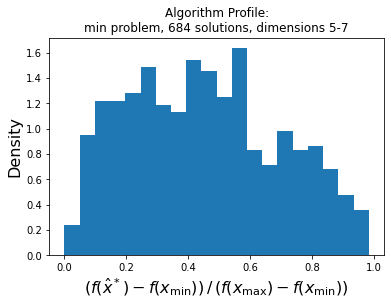

In [9]:
plt.hist(df.performance,density=True,bins=20)
plt.title('Algorithm Profile:\n{} problem, {} solutions, dimensions {}-{}'.\
          format(opt,solution_good,min(df.dimension),max(df.dimension)))
plt.xlabel(r'$(f(\hat{x}^*)-f(x_\min))\,/\,(f(x_\max)-f(x_\min))$',fontsize=16)
plt.ylabel(r'Density',fontsize=16)
plt.show()

In [10]:
print('Mean Performance: {:.2f}'.format(df.performance.mean()))
print('Median Performance: {:.2f}'.format(df.performance.median()))
print('Distribution Modal: {:.2f}'.format(find_modal(df[~df.performance.isna()].performance)))

Mean Performance: 0.45
Median Performance: 0.44
Distribution Modal: 0.47


# Probability

Estimate the probability 
$$Pr[f(\hat{x}^*) < f(x_{\min}) + \epsilon \cdot (f(x_{\max})-f(x_{\min})) \, \vert \, \Omega]$$
for an algorithm predicted optimum $\hat{x}^*$ of $f$ in $\Omega$.

In [11]:
kde = gaussian_kde(df[~df.performance.isna()].performance)

epsilon = 0.4

print('Estimated performance probability: {:.2f}'.format(kde.integrate_box_1d(0,epsilon)))

Estimated performance probability: 0.43
